In [10]:
import os
import os.path
import sys
from IPython.display import clear_output
from time import sleep

import numpy as np
import matplotlib.pyplot as plt
from random import randrange

import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data.sampler import Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Visualize Single Frame

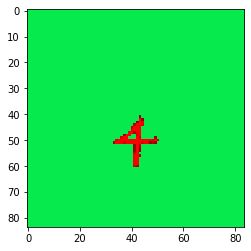

In [11]:
train_directory = '../data/moving_mnist/imgs_train'
val_directory = '../data/moving_mnist/imgs_valid'
npy_path = train_directory + '/4/video_4.npy'
frames = np.load(npy_path)

#Change Background and Plot Image
image = frames[10]
image[np.where((image < [0.5,0.5,0.5]).all(axis=2))] = np.random.rand(3)
plt.imshow(image)

### Visualize Video

In [12]:
def plot_videoframes(frames):
    for i in range(frames.shape[0]//5):
        image = frames[i, :, :, :]
        image[np.where((image < [0.5,0.5,0.5]).all(axis=2))] = np.random.rand(3)
        plt.imshow(image, interpolation='nearest')
        plt.show()
        sleep(0.01)
        clear_output(wait=True)

    plt.close()
    print(frames.shape)
    
#plot_videoframes(frames)

### Background Transformation

In [13]:
# def change_background(img):
#     img[torch.where((img < torch.tensor([0.2,0.2,0.2])).all(axis=2))] = torch.rand(3)
    
class ChangeBackground(object):
    
    def __init__(self, threshold):
        self.threshold_tensor = torch.zeros(3).fill_(threshold)
        self.background_tensor = torch.tensor([[0.9, 0.8, 0.3], [0.5, 0.5, 0.5]])
        
    def __call__(self, sample):
        i = randrange(2)
        background_tensor = self.background_tensor[i]
        sample = sample.permute(1,2,0)
        sample[torch.where((sample < self.threshold_tensor).all(axis=2))] = background_tensor
        sample = sample.permute(2,0,1)
        return sample

### Custom Dataset and Sampler

In [14]:
from data_util.npair_dataset import FramePairsDataset
from data_util.npair_sampler import VideoFrameSampler
import data_util.simclr_transforms as custom_transform

batch_size = 10
frames_per_epoch = 100
transform = transforms.Compose([
    #custom_transform.get_color_distortion(.1),
    custom_transform.RandomGaussianBluring(5, 1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FramePairsDataset(train_directory, '.npy', distance=15, transform=transform)

sampler = VideoFrameSampler(len(dataset), frames_per_epoch, 100)

data_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)

In [15]:
val_dataset = FramePairsDataset(val_directory, '.npy', distance=15, transform=transform)
val_sampler = VideoFrameSampler(len(val_dataset), 10, 100)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, sampler=val_sampler)

### Model and Optimizer

In [19]:
from model.mnist_model import model
from loss.npair_loss import NPairLoss

print(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = NPairLoss(device, batch_size, .001)

Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=6480, out_features=200, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=200, out_features=50, bias=True)
  (12): ReLU()
  (13): Linear(in_features=50, out_features=10, bias=True)
  (14): ReLU()
  (15): Linear(in_features=10, out_features=2, bias=True)
)


### Training the Network

In [20]:
n_pairs_per_epoch = len(sampler)/batch_size
def train(epoch):
    model.train()
    running_loss = 0.0
    lr = optimizer.param_groups[0]['lr']
    for batch_frames in data_loader:
        optimizer.zero_grad()
        anchors = batch_frames[0]
        positives = batch_frames[1]
        anchors, positives = anchors.to(device), positives.to(device)
        r_anchors, r_positives = model(anchors), model(positives)
        loss, accuracy = criterion(r_anchors, r_positives)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch: %3d | Avg Loss: %f | LR : %.9f" 
          % (epoch, running_loss/n_pairs_per_epoch, lr))
    return running_loss


def validation():
    scheduler.step()
    accuracy = 0.0
    for batch_frames in val_loader:
        with torch.no_grad():
            anchors = batch_frames[0]
            positives = batch_frames[1]
            anchors, positives = anchors.to(device), positives.to(device)
            r_anchors, r_positives = model(anchors), model(positives)
            loss, acc = criterion(r_anchors, r_positives)
            accuracy += acc
    return accuracy

model_file = 'mnist.pth'

In [21]:
epochs = 20
max_accuracy = 0
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    train_losses.append(train(epoch))
    accuracy = validation()
    test_accuracies.append(accuracy)
    print("Accuracy = %f" %(accuracy))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        print("Saving model to %s. Accuracy = %f." %(model_file, accuracy))
        torch.save(model.state_dict(), model_file)

Epoch:   0 | Avg Loss: 2.705599 | LR : 0.001000000
Accuracy = 0.450000
Saving model to mnist.pth. Accuracy = 0.450000.
Epoch:   1 | Avg Loss: 2.603736 | LR : 0.001000000
Accuracy = 1.100000
Saving model to mnist.pth. Accuracy = 1.100000.
Epoch:   2 | Avg Loss: 2.604353 | LR : 0.001000000
Accuracy = 0.450000
Epoch:   3 | Avg Loss: 2.493372 | LR : 0.001000000
Accuracy = 1.100000
Saving model to mnist.pth. Accuracy = 1.100000.
Epoch:   4 | Avg Loss: 2.515096 | LR : 0.001000000
Accuracy = 0.650000
Epoch:   5 | Avg Loss: 2.404458 | LR : 0.001000000
Accuracy = 1.150000
Saving model to mnist.pth. Accuracy = 1.150000.
Epoch:   6 | Avg Loss: 2.408203 | LR : 0.001000000
Accuracy = 1.100000
Epoch:   7 | Avg Loss: 2.222904 | LR : 0.001000000
Accuracy = 0.600000
Epoch:   8 | Avg Loss: 2.185315 | LR : 0.001000000
Accuracy = 0.300000
Epoch:   9 | Avg Loss: 2.060635 | LR : 0.001000000
Accuracy = 0.550000
Epoch:  10 | Avg Loss: 2.034607 | LR : 0.000100000
Accuracy = 0.550000
Epoch:  11 | Avg Loss: 1.91

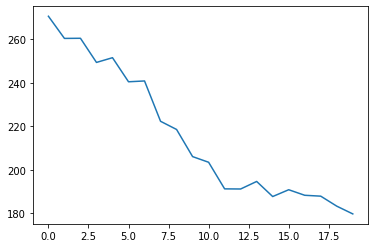

In [22]:
plt.plot(train_losses)